# Understanding LS uncertainties

This notebook follows the explanations in VanderPlas 2017, using the EWs for HeI.

## 0. Loading packages

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u

The cell below defined discrete regular fourrier transforms

In [37]:
def my_ft(time, func, freq):
  '''
  A function to calculate FT manually.
  time: the time array (needs to be regular)
  func: the function of time
  freq: the desired array of frequencies. 
  '''
  ft = np.empty(freq.shape, complex)
  dt = time[1]-time[0]
  for i in range(0,freq.size):
    ft[i] = dt * np.sum( func*np.exp(-1.j*2*np.pi*freq[i]*time) )

  return(ft)

def my_ift(freq, func, time):
  '''
  A function to calculate inverse FT manually.
  freq: the frequency array (needs to be regular)
  func: the function of frequency
  time: the desired array of times. 
  '''
  ift = np.empty(time.shape, complex)
  df = freq[1]-freq[0]
  for i in range(0,time.size):
    ift[i] = df * np.sum( func*np.exp(-1.j*2*np.pi*time[i]*freq) )

  return(ift)

## 1. Loading the EW data.

The data is in the file `03_2023trial_ews_HeI5876.csv` (note, it is in the gitignore, as the results are not yet public)

We open this with Pandas.

In [74]:
data = pd.read_csv('03_2023trial_ews_HeI5876.csv')
# sorting the dataframe in ascending order of HJD
data = data.sort_values(by=["hjd"])

HJD = data["hjd"].to_numpy()
EW = data["EW"].to_numpy()
dEW = data["EW_ERR"].to_numpy()

# We set the zero of our dataset to be the integer HJD just below
# the first datapoint
#print(min(HJD))
HJD0 = 2455795.
HJD = HJD-HJD0

# defining the number of observations
n = HJD.size
print('number of observations: {}'.format(n))

# We set a HJDmax to a round number close to the last datapoint
#print(max(HJD))
HJDmax = 4100.0

number of observations: 48


In the cell below, we plot the EW curve. We will define a test model with a period similar to the expected period for NGC 1624-2.

For the illustration below, we shifted the EW by -40, to match roughly the mean of the EWs. 

Frequency of the model is: 0.006369426751592357 day-1


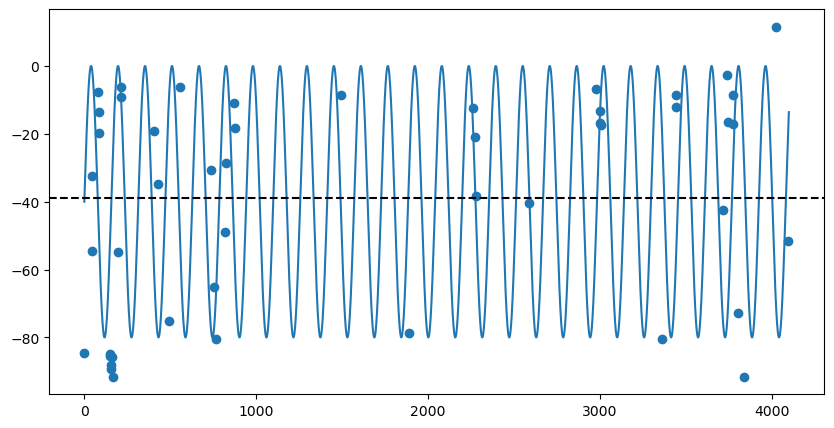

In [166]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(HJD, EW)

model_P = 157.0
model_f = 1/model_P
print('Frequency of the model is: {} day-1'.format(model_f))

def model(t, P):
    A = 40
    EW = A*np.sin(2*np.pi*(t/P))
    return(EW)
    
model_t = np.linspace(0,HJDmax, 5000)
ax.plot(model_t, model(model_t, model_P)-40)

ax.axhline(y=np.mean(EW), ls='--', c='k')

The rectangular window function is $T\simeq4100$ days. This means that the width between the two first zero of the associated sinc function in Fourrier space will be 2/T.

In [161]:
windowFT = 2.0/ (HJDmax)
print(windowFT)

0.0004878048780487805


In the cell below, we illustrate the width of the peak corresponding to the window function of our observations. 
We chose the range of frequencies appropriately around the peak, sampling enough to illustrate the sinc function. 
We also use a very sampled time array, as we are not (yet) showing the effects of the discrete sampling. 

Text(0.5, 0, 'Period (d)')

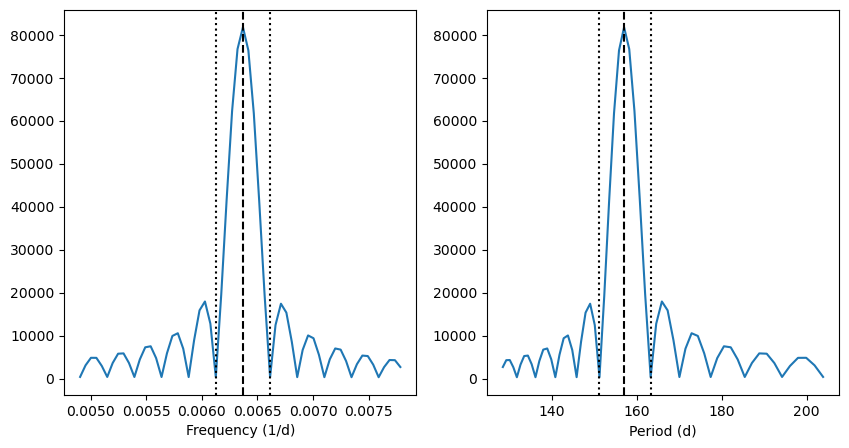

In [168]:
freq = np.arange(model_f-3*windowFT, model_f+3*windowFT , windowFT/10)

model_t = np.linspace(0,HJDmax, 5000)
FT = my_ft(model_t, model(model_t, model_P), freq)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(freq, np.abs(FT))
ax[0].axvline(x=model_f, ls='--', c='k')
ax[0].axvline(x=model_f+windowFT/2, c='k', ls='dotted')
ax[0].axvline(x=model_f-windowFT/2, c='k', ls='dotted')
ax[0].set_xlabel('Frequency (1/d)')

ax[1].plot(1/freq, np.abs(FT))
ax[1].axvline(model_P, ls='--', c='k' )
ax[1].axvline(1/(model_f+windowFT/2), ls='dotted', c='k')
ax[1].axvline(1/(model_f-windowFT/2), ls='dotted', c='k')
ax[1].set_xlabel('Period (d)')

In the figure above, we have restricted the calculation to positive frequencies. But mathematically, negative frequencies will also show a peak at the appropriate negative frequency, as illustrated below. 

This is important to keep in mind when we discuss the sampling below. 

Text(0.5, 0, 'Frequency (1/d)')

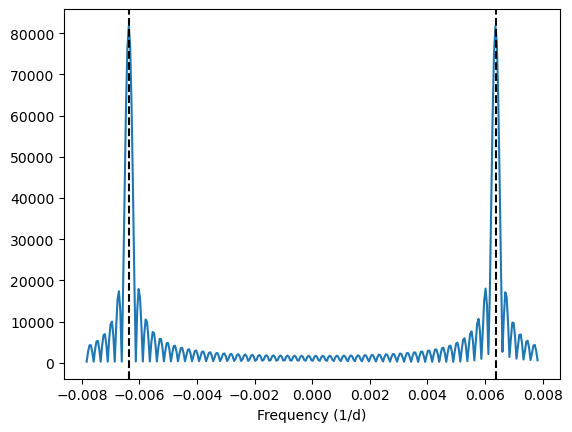

In [172]:
freq = np.arange(-1*(model_f+3*windowFT), model_f+3*windowFT , windowFT/10)
model_t = np.linspace(0,HJDmax, 5000)
FT = my_ft(model_t, model(model_t, model_P), freq)

fig, ax = plt.subplots(1,1)
ax.plot(freq, np.abs(FT))
ax.axvline(x=model_f, ls='--', c='k')
ax.axvline(x=-1*model_f, ls='--', c='k')
ax.set_xlabel('Frequency (1/d)')

Now, let's look at the sampling of our observations. 

The smallest, largest, and mean time intervals in our observations are:

In [163]:
print(np.min(HJD[1:]-HJD[0:-1]))
print(np.max(HJD[1:]-HJD[0:-1]))
print(np.mean((HJD[1:]-HJD[0:-1])))

0.93586351769045
620.1327030998655
87.16586003617007


The sampling is the equivalent of multiplying our signal with a comb function (with interval $T$). This means that the FT of the signal will the convolved with the FT of a comb, which is also a comb with spacing corresponding to $1/T$. 

In the example below, we sample the sin signal model with a 30 days cadence (a bit lower than the mean cadence in our data, for illustration). (Note that we vertically centered the EW at zero for these calculations)

The aliases will be spaced by 0.03333333333333333 1/d


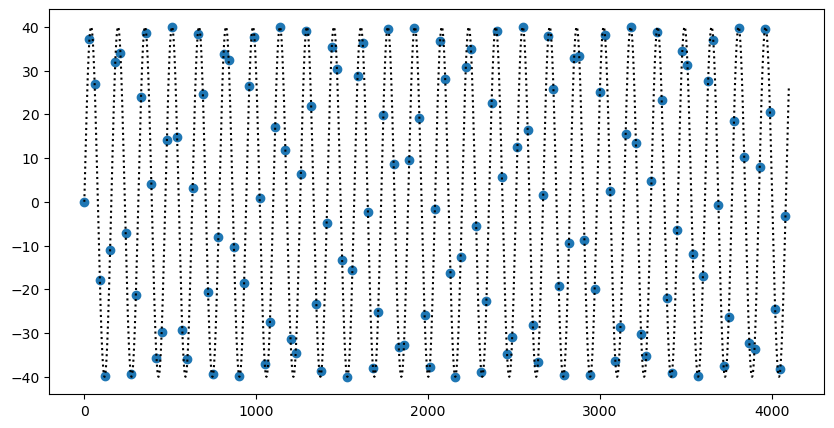

In [183]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

model_P=157
sample = 30

print('The aliases will be spaced by {} 1/d'.format(1/sample))

sample_t = np.arange(0,HJDmax, sample)
ax.scatter(sample_t, model(sample_t, model_P))
ax.plot(model_t, model(model_t, model_P), ls="dotted", c='k')

Because of the sampling, we therefore we expect the FT that we found above (two peaks at $\pm0.006$ 1/d) to be repeated every 0.03 days. 

In the figure below, we sampled only positive frequencies, and the first peak (dashed vertical line) is the 0.006 1/d frequency. 

The dotted vertical lines show intervals of 0.03 days, and we can see the two peaks on either sides

/var/folders/b0/wx58lg256fd4p48kl1w5l1zw0000gp/T/ipykernel_28222/2238901143.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(1/freq, np.abs(FT))


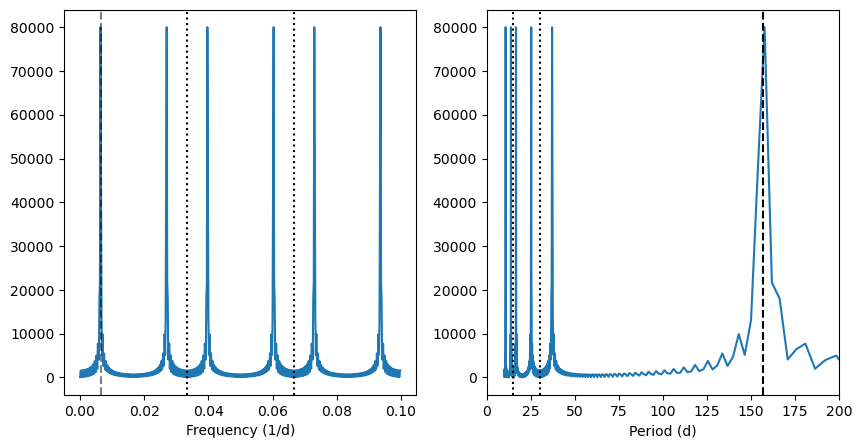

In [184]:
freq = np.arange(0, 3/sample , windowFT/3)

FT = my_ft(sample_t, model(sample_t, model_P), freq)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(freq, np.abs(FT))

ax[0].axvline(x=model_f, ls='--', c='k', alpha=0.5)
ax[0].axvline(x=1/sample, ls='dotted', c='k')
ax[0].axvline(x=2/sample, ls='dotted', c='k')

ax[0].set_xlabel('Frequency (1/d)')

ax[1].plot(1/freq, np.abs(FT))
ax[1].axvline(model_P, ls='--', c='k')
ax[1].set_xlabel('Period (d)')
ax[1].set_xlim(0,200)
ax[1].axvline(x=sample, ls='dotted', c='k')
ax[1].axvline(x=sample/2, ls='dotted', c='k')

As the sampling gets more sparse (the frequency $f_s$ of the sampling becomes smaller), the dotted lines that are caused by the convolution by the comb function in frequency will shift to lower frequencies.

Therefore at some point, the $f_o$ peak at 0.006 1/d that is related to our signal will be blended with the peak at the left of the first dotted line. 

The peak will overlap when the sampling frequency is smaller than $2\times f_o$. 

In our case, this would be $2\times 0.006$ 1/d = 0.012 1/d, which is 83 days (give or take).

In the figure below, we illustrate how the frequency periodogram changes when the sampling increases from 30 days to 80 days. The dash line again shows the signal frequency and the dotted lines show the spacing of the repetitions caused by the comb function. 

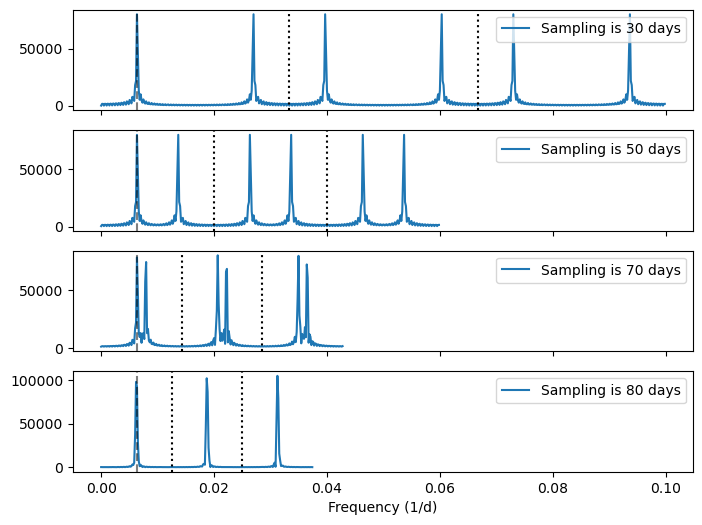

In [192]:
sample_array = np.array([30, 50, 70, 80])
fig, ax = plt.subplots(sample_array.size,1, figsize=(8,6), sharex=True)

for i, sample in enumerate(sample_array):

    sample_t = np.arange(0,HJDmax, sample)
    freq = np.arange(0, 3/sample , windowFT/3)

    FT = my_ft(sample_t, model(sample_t, model_P), freq)
    ax[i].plot(freq, np.abs(FT), label='Sampling is {} days'.format(sample))

    ax[i].axvline(x=model_f, ls='--', c='k', alpha=0.5)
    ax[i].axvline(x=1/sample, ls='dotted', c='k')
    ax[i].axvline(x=2/sample, ls='dotted', c='k')

ax[-1].set_xlabel('Frequency (1/d)')
for item in ax:
    item.legend(loc=1)

Another way to think about this is that for each sampling, there is a limit to the frequencies that can be recovered. Going back to the 30 day sampling in the top panel of the figure below, we can imagine what would happen if the frequency of our signal was different than 0.006 1/d. 
- If the frequency was smaller (longer period), the main peak (dashed line) would move to the left, and the peaks surrrounding the dotted lines would be closer to the dotted line. 
- If the frequency was larger (shorter period), the main peak (dashed line) would move to the right, and the peaks surrounding the dotted lines would be farter away from the dotted line. 

The figure below illustrates this. 

If the frequency increases, there will be a point where the peaks would overlap. This frequency would be $f_s/2$. In our case, if the sampling is 0.033 1/d, this corresponds to a max frequency of 0.016 1/d (or a min period of 60 days). 

In the figure below, we shade the region corresponding to the frequencies that are recoverable with this sampling. 

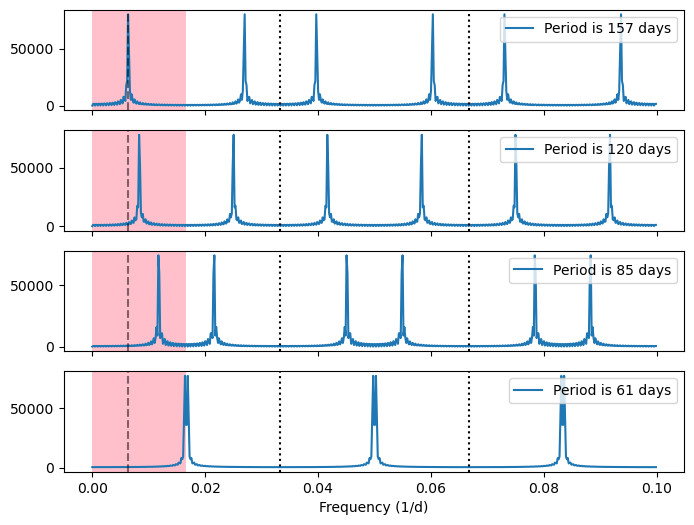

In [211]:
sample = 30
period_array = np.array([157, 120, 85, 61])
fig, ax = plt.subplots(period_array.size,1, figsize=(8,6), sharex=True)

for i, model_P in enumerate(period_array):

    sample_t = np.arange(0,HJDmax, sample)
    freq = np.arange(0, 3/sample , windowFT/3)

    FT = my_ft(sample_t, model(sample_t, model_P), freq)
    ax[i].plot(freq, np.abs(FT), label='Period is {} days'.format(model_P))

    ax[i].axvline(x=model_f, ls='--', c='k', alpha=0.5)
    ax[i].axvline(x=1/sample, ls='dotted', c='k')
    ax[i].axvline(x=2/sample, ls='dotted', c='k')

ax[-1].set_xlabel('Frequency (1/d)')
for item in ax:
    item.legend(loc=1)
    item.axvspan(xmin=0,xmax=1/sample/2, fc='pink')

Going back to our figure for our 157 d period and various sampling, we can also below shade the region of frequencies in the periodogram that can be recovered in the signal. The main peak (dashed line) is in the shaded regions for the first few sampling rates, but not the the last rate, which corresponded to the minimum sampling rate. 

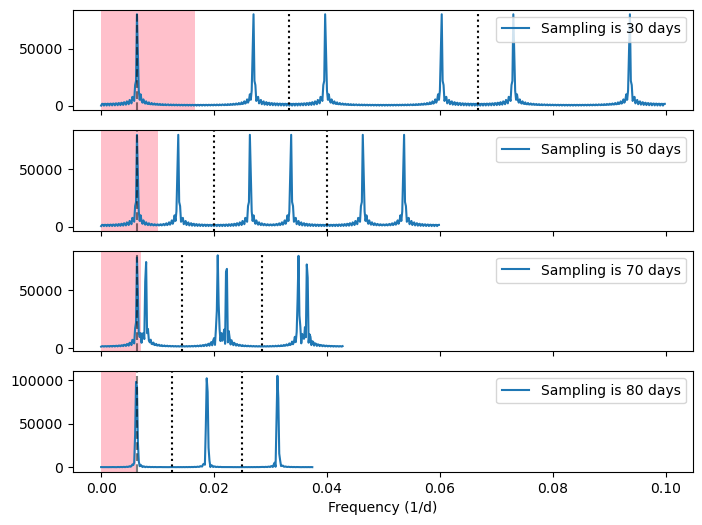

In [214]:
sample_array = np.array([30, 50, 70, 80])
model_P = 157
fig, ax = plt.subplots(sample_array.size,1, figsize=(8,6), sharex=True)

for i, sample in enumerate(sample_array):

    sample_t = np.arange(0,HJDmax, sample)
    freq = np.arange(0, 3/sample , windowFT/3)

    FT = my_ft(sample_t, model(sample_t, model_P), freq)
    ax[i].plot(freq, np.abs(FT), label='Sampling is {} days'.format(sample))

    ax[i].axvline(x=model_f, ls='--', c='k', alpha=0.5)
    ax[i].axvline(x=1/sample, ls='dotted', c='k')
    ax[i].axvline(x=2/sample, ls='dotted', c='k')
    ax[i].axvspan(xmin=0,xmax=1/sample/2, fc='pink')

ax[-1].set_xlabel('Frequency (1/d)')
for item in ax:
    item.legend(loc=1)